<a href="https://colab.research.google.com/github/nayanapreethi/AICTE-Internships-2025-June-GHG-Emissions-Prediction/blob/main/GHG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


📥 Loading Excel Data...


🧹 Preprocessing Data...


📐 Splitting and Scaling Data...


🤖 Training Models...


🏆 Model Leaderboard:

              Model        R2      RMSE       MAE
4  LinearRegression  0.999999  0.000281  0.000097
0      RandomForest  0.999395  0.005827  0.000758
2     GradientBoost  0.999304  0.006252  0.002348
1           XGBoost  0.994739  0.017191  0.001985
3               SVR  0.925445  0.064713  0.047289

🔍 Plotting Feature Importance...



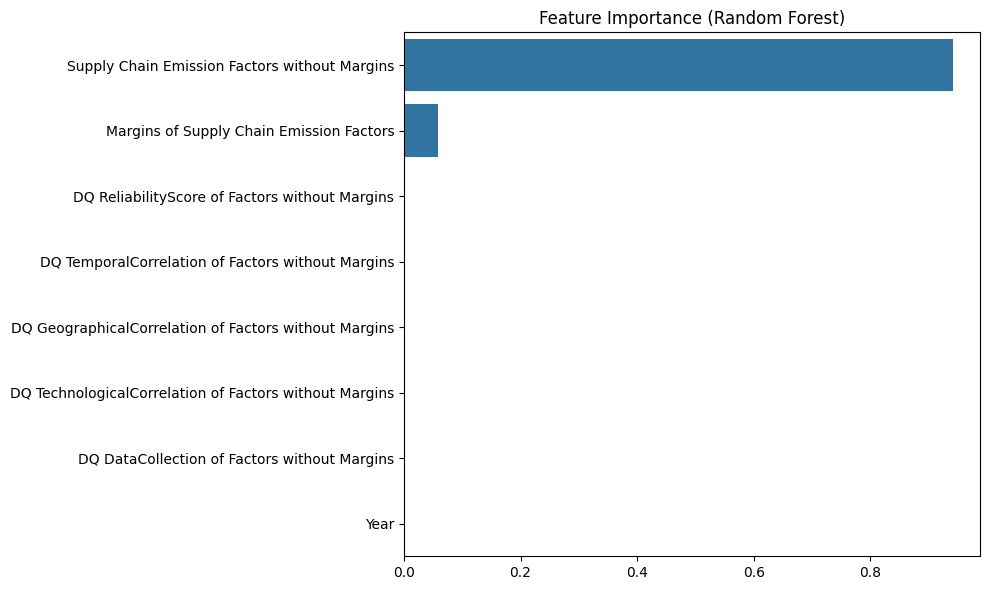


📆 Plotting Emission Trends by Year...



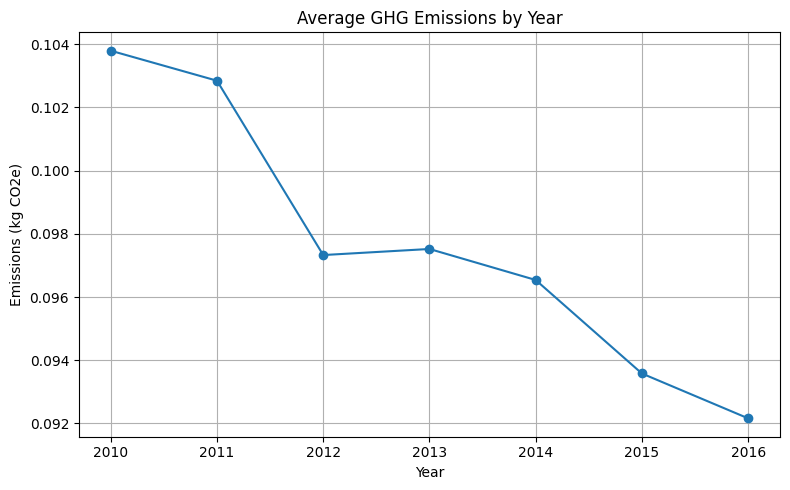


🔄 Converting Predictions to Tonnes...


📊 SHAP Explainability (Bar Plot)...



 98%|===================| 4349/4419 [00:15<00:00]       

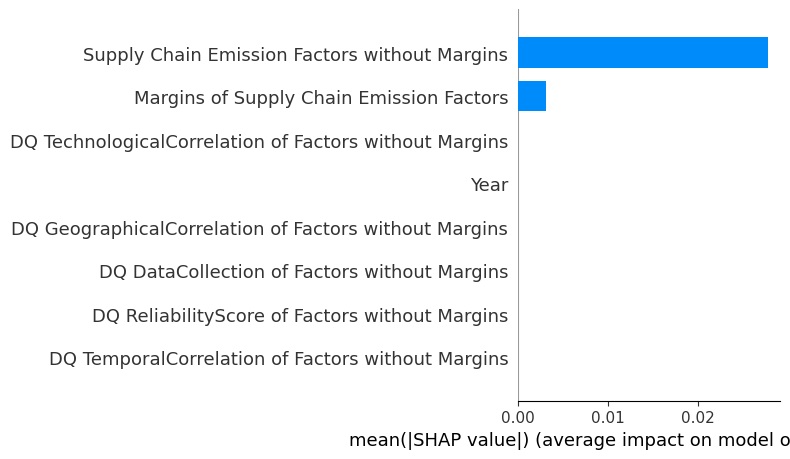


📌 Optimization Suggestions:

- Consider reducing high-impact features like:
  • Supply Chain Emission Factors without Margins
  • Margins of Supply Chain Emission Factors
  • Improve data collection quality and reduce uncertainty

💡 Enter values for prediction:


FloatText(value=0.0, description='Supply Chain Emission Factors without Margins:')

FloatText(value=0.0, description='Margins of Supply Chain Emission Factors:')

FloatText(value=0.0, description='DQ ReliabilityScore of Factors without Margins:')

FloatText(value=0.0, description='DQ TemporalCorrelation of Factors without Margins:')

FloatText(value=0.0, description='DQ GeographicalCorrelation of Factors without Margins:')

FloatText(value=0.0, description='DQ TechnologicalCorrelation of Factors without Margins:')

FloatText(value=0.0, description='DQ DataCollection of Factors without Margins:')

FloatText(value=0.0, description='Year:')

Button(description='Predict', style=ButtonStyle())

Output()

In [5]:
# 📦 Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import os
import ipywidgets as widgets
from IPython.display import display, clear_output


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb


# 📥 Load and Merge Excel Sheets (2010–2016)
print("\n📥 Loading Excel Data...\n")
excel_file = '/content/af60b10b8dad38110304.xlsx'
years = range(2010, 2017)
all_data = []

for year in years:
    try:
        df_com = pd.read_excel(excel_file, sheet_name=f'{year}_Detail_Commodity')
        df_ind = pd.read_excel(excel_file, sheet_name=f'{year}_Detail_Industry')
        df_com['Source'] = 'Commodity'; df_ind['Source'] = 'Industry'
        df_com['Year'] = df_ind['Year'] = year
        df_com.columns = df_com.columns.str.strip()
        df_ind.columns = df_ind.columns.str.strip()
        df_com.rename(columns={'Commodity Code': 'Code', 'Commodity Name': 'Name'}, inplace=True)
        df_ind.rename(columns={'Industry Code': 'Code', 'Industry Name': 'Name'}, inplace=True)
        all_data.append(pd.concat([df_com, df_ind], ignore_index=True))
    except Exception as e:
        print(f"❌ Error loading year {year}: {e}")

# 📊 Combine and Clean Data
print("\n🧹 Preprocessing Data...\n")
df = pd.concat(all_data, ignore_index=True)
target_column = 'Supply Chain Emission Factors with Margins'
feature_columns = [
    'Supply Chain Emission Factors without Margins',
    'Margins of Supply Chain Emission Factors',
    'DQ ReliabilityScore of Factors without Margins',
    'DQ TemporalCorrelation of Factors without Margins',
    'DQ GeographicalCorrelation of Factors without Margins',
    'DQ TechnologicalCorrelation of Factors without Margins',
    'DQ DataCollection of Factors without Margins',
    'Year'
]
X = df[feature_columns].apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(df[target_column], errors='coerce')
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# 🔀 Train-Test Split and Scaling
print("\n📐 Splitting and Scaling Data...\n")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🤖 Train & Compare Multiple ML Models
print("\n🤖 Training Models...\n")
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'GradientBoost': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'LinearRegression': LinearRegression()
}

results = []
best_model = None # Initialize best_model before the loop
best_preds = None # Initialize best_preds here
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    results.append((name, r2, rmse, mae))

    if name == 'RandomForest':
        os.makedirs("models", exist_ok=True)
        joblib.dump(model, 'models/rf_model.joblib')
        best_model = model
        best_preds = preds


# 📈 Display Leaderboard
print("\n🏆 Model Leaderboard:\n")
leaderboard = pd.DataFrame(results, columns=['Model', 'R2', 'RMSE', 'MAE'])
print(leaderboard.sort_values(by='R2', ascending=False))

# 📊 Feature Importance
print("\n🔍 Plotting Feature Importance...\n")
importances = best_model.feature_importances_
os.makedirs("images", exist_ok=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_columns)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.savefig("images/feature_importance.png")
plt.show()

# 📉 Time Series Trend
print("\n📆 Plotting Emission Trends by Year...\n")
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
plt.figure(figsize=(8, 5))
df.groupby('Year')[target_column].mean().plot(marker='o')
plt.title("Average GHG Emissions by Year")
plt.ylabel("Emissions (kg CO2e)")
plt.grid(True)
plt.tight_layout()
plt.savefig("images/yearly_trend.png")
plt.show()

# 🔄 Unit Conversion
print("\n🔄 Converting Predictions to Tonnes...\n")
best_preds_tonnes = best_preds / 1000

# 🔍 Explainability with SHAP
print("\n📊 SHAP Explainability (Bar Plot)...\n")
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 🤖 Optimization Insight (Textual Suggestion)
# 🤖 Optimization Insight (Textual Suggestion)
print("\n📌 Optimization Suggestions:\n")
print("- Consider reducing high-impact features like:")
print("  • Supply Chain Emission Factors without Margins")
print("  • Margins of Supply Chain Emission Factors")
print("  • Improve data collection quality and reduce uncertainty")


# 🗣️ Function to get user input and make predictions
def predict_with_user_input(button):
    with output:
        clear_output()
        print("\n💡 Collecting values for prediction...\n")

        input_values = {}
        for feature in feature_columns:
            # Get the value from the corresponding widget
            input_values[feature] = input_widgets[feature].value

        # Create a DataFrame from user input
        user_df = pd.DataFrame([input_values])

        # Ensure column order matches the training data
        user_df = user_df[feature_columns]

        # Scale the user input using the same scaler fitted on training data
        user_scaled = scaler.transform(user_df)

        # Make prediction using the best model (Random Forest)
        user_prediction = best_model.predict(user_scaled)

        print(f"\n🔮 Predicted Supply Chain Emission Factor: {user_prediction[0]:.4f} kg CO2e")
        print(f"🔮 Predicted Supply Chain Emission Factor: {(user_prediction[0] / 1000):.4f} tonnes CO2e")

# Create input widgets for each feature
input_widgets = {}
print("\n💡 Enter values for prediction:")
for feature in feature_columns:
    input_widgets[feature] = widgets.FloatText(description=f"{feature}:")
    display(input_widgets[feature])

# Create a button to trigger the prediction
predict_button = widgets.Button(description="Predict")
output = widgets.Output()

# Link the button to the prediction function
predict_button.on_click(predict_with_user_input)

# Display the button and output area
display(predict_button, output)